In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

import time

from sklearn.metrics import mean_absolute_error

In [ ]:
limit_ListPrice = 1800
price_segment = 30
customer_traffic_segment = 0.0833 #5/(limit_ListPrice/price_segment)
competitiveness_segment = 0.0416 #2.5/(limit_ListPrice/price_segment)
epsilon = 0.4

# Dynamic Pricing with Reinforcement Learning

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
df_byhotels2 = np.load("/content/drive/My Drive/Colab Notebooks/dynamic_pricing/data/preprocessed_data_v3_groupbyhotels.npy", allow_pickle=True)


In [ ]:
df_byhotels=[]
for df in df_byhotels2:
    df = df[df['ListPriceTRY']<=limit_ListPrice]
    df = df[df['PurchaseAmountTRY']<=limit_ListPrice]
    print('------------------------------------------------------------------------')
    print('Max Purchase Amount:', df['PurchaseAmountTRY'].max() , 'Min Purchase Amount:', df['PurchaseAmountTRY'].min())
    print('Max List Price:', df['ListPriceTRY'].max() , 'Min List Price:', df['ListPriceTRY'].min() )
    print('Max Rate:', df['RatingTripA'].max(), 'Min Rate:', df['RatingTripA'].min())
    print('Max Feature Score:', df['featureScore'].max() , 'Min Feature Score:', df['featureScore'].min())
    print('Max Room Count:', df['empty_rooms'].max() , 'Min Room Count:', df['empty_rooms'].min())
    print('------------------------------------------------------------------------')
    df_byhotels.append(df)

------------------------------------------------------------------------
Max Purchase Amount: 1610.0 Min Purchase Amount: 407.3
Max List Price: 1788.833333333333 Min List Price: 486.2
Max Rate: 4.5 Min Rate: 4.5
Max Feature Score: 2.2538542161050463 Min Feature Score: 2.2538542161050463
Max Room Count: 369.001 Min Room Count: 0.001
------------------------------------------------------------------------
------------------------------------------------------------------------
Max Purchase Amount: 1590.25 Min Purchase Amount: 402.44767441860466
Max List Price: 1714.0 Min List Price: 518.4186046511628
Max Rate: 4.5 Min Rate: 4.5
Max Feature Score: 1.5844853574504736 Min Feature Score: 1.5844853574504736
Max Room Count: 215.001 Min Room Count: 0.001
------------------------------------------------------------------------
------------------------------------------------------------------------
Max Purchase Amount: 1581.8285714285714 Min Purchase Amount: 406.21962616822435
Max List Price: 17

In [ ]:
# Utility function for creating discreate space
def round_specific(x, precision, base):
  return round(base * round(float(x)/base),precision)

In [ ]:
class Sale:
    def __init__(self, purchase, customer_traffic, competitiveness, empty_rooms):
        self.profit = round_specific(np.random.rand()*0.2, 2, 0.01)
        self.purchase = purchase
        if self.purchase > limit_ListPrice:
            self.purchase = limit_ListPrice
        if self.purchase < 0:
            self.purchase = 0
        
        self.list_price = self.purchase + self.purchase*self.profit
        self.list_price = round_specific(self.list_price, 0, price_segment)
        if self.list_price > limit_ListPrice:
            self.list_price = limit_ListPrice
        if self.list_price < 0:
            self.list_price = 0

        self.customer_traffic = customer_traffic
        self.competitiveness = competitiveness
        self.empty_rooms = empty_rooms
    
    def __str__(self):
        return f"{self.profit}"
    
    def __sub__(self,other):
        return self.profit - other.profit
    
    def action(self, choice):
        if choice == 0:
            self.change(-5) # profiti %5 indir
        elif choice == 1:
            self.change(0) 
        elif choice == 2:
            self.change(+10) 
        """
        elif choice == 3:
            self.change(+5) 
        elif choice == 4:
            self.change(+10) # profiti %10 arttir 
        """
    
    def change(self, p=False):
        if not p:
            self.profit = round_specific(np.random.rand(), 2, 0.01)
        else:
            self.profit = self.profit + (p/100)
            
        self.list_price = self.purchase + self.purchase*self.profit 
        self.list_price = round_specific(self.list_price, 0, price_segment)
        if self.list_price > limit_ListPrice:
            self.list_price = limit_ListPrice
        if self.list_price < 0:
            self.list_price = 0

In [ ]:
q_table_main = np.load('/content/drive/My Drive/Colab Notebooks/dynamic_pricing/data/qtable/q_table_30_1800_3acts.npy',allow_pickle='TRUE').item()

In [ ]:
def RL(HM_EPISODES, epsilon, df, q_table):
    EPS_DECAY = 0.998
    SHOW_EVERY = 100
    LEARNING_RATE = 0.1
    DISCOUNT = 0.95
    df['list_price']=np.nan

    episode_rewards = []

    for episode in range(HM_EPISODES):
    
        sale = df.iloc[episode]
        
        purchase = sale['PurchaseAmountTRY']
        purchase = round_specific(purchase, 0, 30)
        
        customer_traffic = sale['RatingTripA']
        customer_traffic = round_specific(customer_traffic, 1, 0.0833)
        
        competitiveness = sale['featureScore']
        competitiveness = round_specific(competitiveness, 2, 0.0416)
        
        empty_rooms = sale['empty_rooms']
        
        agent = Sale(purchase, customer_traffic, competitiveness, empty_rooms)
        
        list_price = agent.list_price
        """
        if episode % SHOW_EVERY == 0:
            print(f"on #{episode}, epsilon is {epsilon}")
            print(f"{SHOW_EVERY} ep mean: {np.mean(episode_rewards[-SHOW_EVERY:])}")
            show = True
        else:
            show = False
        """
        episode_reward = 0
        for i in range(200):
            obs = (purchase, list_price, customer_traffic, competitiveness)
            
            if np.random.random() > epsilon:
                # GET THE ACTION
                action = np.argmax(q_table[obs])
            else:
                action = np.random.randint(0, 3)
            
            # Take the action!
            agent.action(action)
            
            ##############################
            # REWARD FUNCTION
            new_obs = (agent.purchase, agent.list_price, agent.customer_traffic, agent.competitiveness)
            max_future_q = np.max(q_table[new_obs])
            
            #Kıymet
            #mean yapınca.
            #max_future_q = np.mean(q_table[new_obs])

   
            current_q = q_table[obs][action]
            


            rewardrate = (agent.list_price-agent.purchase)/ agent.empty_rooms
            
            if rewardrate < 1:
                reward = -300
                new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)
            elif rewardrate < 10 or rewardrate > 1000:
                new_q = rewardrate
                reward = 25
            else:
                reward = -1
                new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)
            
            q_table[obs][action] = new_q

            episode_reward += reward
            if reward ==25:
                break
        df['list_price'].iloc[episode] = agent.list_price
        #print(episode_reward)
        episode_rewards.append(episode_reward)
        epsilon *= EPS_DECAY

    moving_avg = np.convolve(episode_rewards, np.ones((SHOW_EVERY,))/SHOW_EVERY, mode='valid')
    return df, moving_avg

**Hotel Based Pricing**

In [ ]:
df_1M = df_byhotels


df_list = df_1M

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


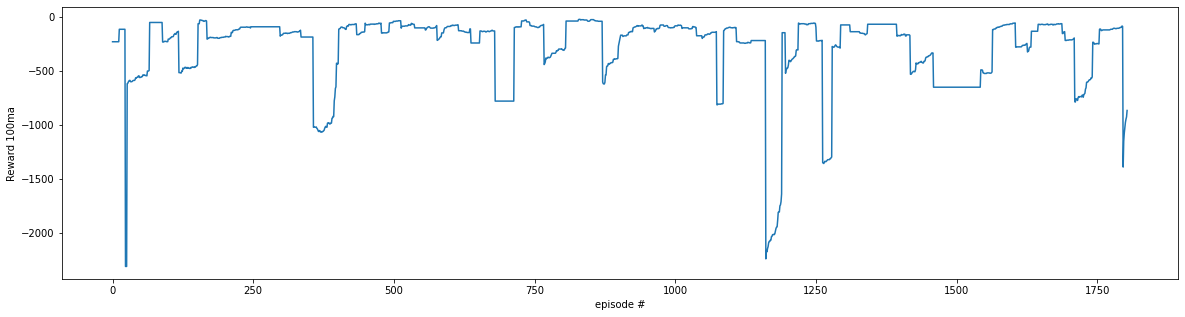

In [ ]:
moving_avg_all = np.array([])
for data_frame in df_list:
  q_table = q_table_main.copy()
  data_frame.reset_index()
  data_frame, moving_avg = RL(data_frame.shape[0], 0.4, data_frame, q_table)
  moving_avg_all = np.concatenate((moving_avg_all, moving_avg), axis=None)


plt.rcParams['figure.figsize'] = [20, 5]
plt.plot([i for i in range(len(moving_avg_all))], moving_avg_all)
plt.ylabel(f"Reward 100ma")
plt.xlabel("episode #")
plt.show()

In [ ]:
c = pd.concat(df_list)
df_list.append(c)

<Figure size 1440x360 with 0 Axes>

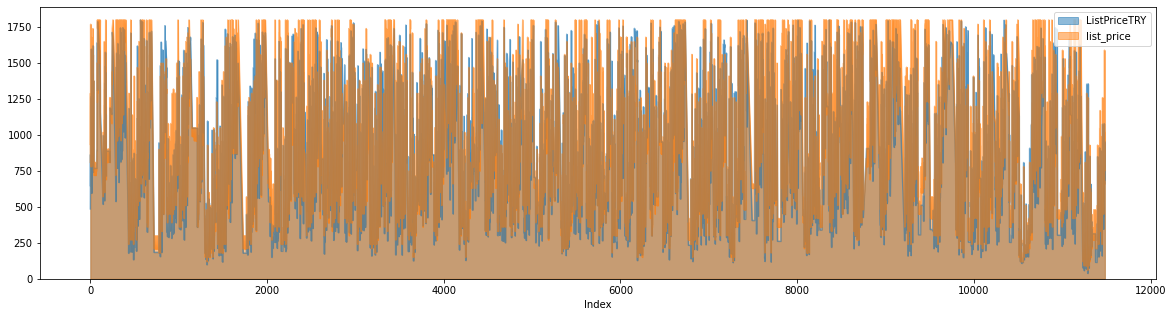

In [ ]:
df_1M2 = c[['ListPriceTRY','list_price']]
plt.figure();
plt.rcParams['figure.figsize'] = [20, 5]
df_1M2.plot.area(stacked=False);

**Original List Price Classfication**

In [ ]:
# Utility function for creating discreate space
def round_specific_series(x, precision, base):
  return round(base * round(x/base),precision)

**Mean Absolute Percentage Error**

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

**Print Metrics**

In [ ]:
def print_metrics(data_frame):

  print("*Number of Sales: ",data_frame.shape[0])
  print("*Mean Absolute Error: ", mean_absolute_error(data_frame['ListPriceTRY'],data_frame['list_price']));

  print("*MAPE of Or-Re: ", mean_absolute_percentage_error(data_frame['ListPriceTRY'],data_frame['list_price']));

  print("*Mean of Recommended List Prices:", data_frame['list_price'].mean())
  print("*Mean of Original List Prices:", data_frame['ListPriceTRY'].mean())

  print("*Standard Deviation of Recommended List Prices:", data_frame['list_price'].std())
  print("*Standard Deviation of Original List Prices:", data_frame['ListPriceTRY'].std())
  
  return

In [ ]:
for d in df_list:
  print_metrics(d)
  print("|")

*Number of Sales:  89
*Mean Absolute Error:  122.69610566424751
*Mean Absolute Error of Classified:  127.97752808988764
*h460 MAPE of Or-Re:  12.70845254189653
*h460 MAPE of Cl-Re:  13.318726685299712
*Mean of Recommended List Prices: 1088.426966292135
*Mean of Original List Prices: 1005.356523838854
*Mean of Classified List Prices: 1016.8539325842696
*Standard Deviation of Recommended List Prices: 359.65860983464864
*Standard Deviation of Original List Prices: 322.11189931147027
*Standard Deviation of Classified List Prices: 312.69937460187623
|
*Number of Sales:  90
*Mean Absolute Error:  80.44938062367302
*Mean Absolute Error of Classified:  82.11111111111111
*h460 MAPE of Or-Re:  9.268534963124267
*h460 MAPE of Cl-Re:  9.805313994284578
*Mean of Recommended List Prices: 1018.3333333333334
*Mean of Original List Prices: 972.6955386035183
*Mean of Classified List Prices: 974.4444444444445
*Standard Deviation of Recommended List Prices: 278.875148255643
*Standard Deviation of Original

In [ ]:
df_1M=df_list[-1]

In [ ]:
df_1M['col1'] = np.where(df_1M['ListPriceTRY'] > df_1M['list_price'], True, False)
df_1M['col2'] = np.where(df_1M['ListPriceTRY'] == df_1M['list_price'], True, False)
df_1M['col3'] = np.where(df_1M['ListPriceTRY'] < df_1M['list_price'], True, False)

In [ ]:
df_1M

,DWHotelID,Unnamed: 0,w,Date,ListPriceTRY,PurchaseAmountTRY,RatingTripA,ProfitRate,featureScore,Date_year,Date_week,rooms_old,#rooms,empty_rooms,rewardrate,list_price,ClassifiedListPriceTRY,col1,col2,col3
Index,,,,,,,,,,,,,,,,,,,,
0,58.0,0,10.0,2013-21,486.200000,407.300000,4.5,0.193715,2.253854,2013,21,2.0,379.0,369.001,0.213821,810.0,500.0,False,False,True
1,58.0,1,12.0,2013-22,805.833333,639.416667,4.5,0.260263,2.253854,2013,22,2.0,379.0,367.001,0.453450,1230.0,800.0,False,False,True
2,58.0,2,31.0,2013-23,863.870968,691.387097,4.5,0.249475,2.253854,2013,23,2.0,379.0,348.001,0.495642,1290.0,900.0,False,False,True
3,58.0,3,58.0,2013-24,643.258621,516.724138,4.5,0.244878,2.253854,2013,24,2.0,379.0,321.001,0.394187,930.0,600.0,False,False,True
4,58.0,4,50.0,2013-25,1223.840000,988.900000,4.5,0.237577,2.253854,2013,25,2.0,379.0,329.001,0.714101,1770.0,1200.0,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11478,390.0,11478,40.0,2018-33,940.575000,850.675000,4.0,0.105681,0.607659,2018,33,17.0,119.0,79.001,1.137960,1590.0,900.0,False,False,True
11479,390.0,11479,54.0,2018-34,682.240741,609.777778,4.0,0.118835,0.607659,2018,34,17.0,119.0,65.001,1.114798,750.0,700.0,False,False,True
11480,390.0,11480,34.0,2018-35,953.764706,843.205882,4.0,0.131117,0.607659,2018,35,17.0,119.0,85.001,1.300677,1020.0,1000.0,False,False,True


In [ ]:
df_1M.to_csv(r'/content/drive/My Drive/Colab Notebooks/dynamic_pricing/data/qlearning_results_3018003acts_byhotels.csv', index = False)
